Dave Brunner
Group G27

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

1. Download the dataset from kaggle (see the link in the notebook). Load it into a pandas dataframe (see the code in the notebook). Normalise the data.
2. Complete the code for the implementation of the methods \verb|predict|, \verb|cost|, \verb|gradient_cost|, \verb|accuracy|. As a test, just invoke the method by suitable dummy values.
3. Implement (full) batch GD for minimizing the CE cost (without autograd). Plot cost vs the number of epochs.
4. Implement (full) batch GD for minimizing the CE cost, this time with autograd. show that you obtain consistent results.
5. Tune the learning rate. What is a reasonable learning rate?

### 1. Load Data

In [2]:
import pandas as pd
df = pd.read_csv("./data/Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.172987,6.330911,63.000000,56.842076,110.644021,42.608076,0.234335,24.5629,11.0730,16.30352,-4.447261,41.3260,Abnormal
1,88.623908,29.089453,47.564262,59.534455,121.764780,51.805899,0.770614,13.1962,13.6590,15.27164,-4.208953,32.9340,Abnormal
2,83.933009,41.286305,62.000000,42.646703,115.012334,26.588100,0.614767,8.8345,7.2405,9.79573,-20.130727,22.4032,Abnormal
3,74.094731,18.823727,76.032156,55.271004,128.405731,73.388216,0.910886,13.1813,10.1368,8.49572,-0.337130,11.6844,Abnormal
4,70.676898,21.704402,59.181161,48.972496,103.008354,27.810148,0.039655,15.7748,14.8568,11.45991,-18.475476,19.8407,Abnormal


#### Normalization and Turning into Torch Tensors

In [3]:
x0 = torch.from_numpy(shuffled_df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==shuffled_df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

print(X[:1,:])
print(Y[:1,:])

torch.Size([310, 12]) torch.Size([310, 1])
tensor([[ 0.1553, -1.1203,  0.5966,  1.0347, -0.5464,  0.4343, -0.8350,  0.3752,
         -0.5858,  1.5105,  0.7857,  1.5004]], dtype=torch.float64)
tensor([[1]], dtype=torch.int32)


### 2. Implement the Model for (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [4]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)
X[1,:]

tensor([ 1.0000,  1.6318,  1.1537, -0.2353,  1.2352,  0.2887,  0.6792,  1.0415,
        -0.9405,  0.1749,  1.1538,  0.8052,  0.6974], dtype=torch.float64)

In [5]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def sigmoid(x):
    return 1/(1+ np.exp(-x))

def predict(X,W):
    if X.shape[1] != W.shape[0]:
        raise ValueError("Shape mismatch: X and W must have compatible shapes for matrix multiplication.")
    z = torch.matmul(X, W)
    return sigmoid(z)

def binary_cross_entropy_loss(X,Y,W):
    y_pred = predict(X,W)
    epsilon = 1e-7  # Small value to avoid log(0)
    return -torch.mean(Y * torch.log(y_pred + epsilon) + (1 - Y) * torch.log(1 - y_pred + epsilon))
    

In [6]:
def gradient_cost(X,Y,W):
    y_pred = predict(X,W)
    return torch.matmul(X.t(), y_pred - Y) / len(Y)
        
def accuracy(Y,Yhat):
    flattened_predictions = torch.where(Yhat >= 0.5, torch.tensor(1), torch.tensor(0))
    num_correct = torch.sum(Y == flattened_predictions).item()
    num_samples = Y.numel()
    return num_correct / num_samples

Just for testing:

In [7]:
W = torch.randn(13,1, dtype=torch.double)
predict(X,W)
binary_cross_entropy_loss(X,Y,W)

tensor(2.1804, dtype=torch.float64)

### 3. Implement Full Batch Gradient Descent

Training Accuracy (max,end): 0.867742, 0.858065
Training Cost (end): 0.304605


Text(0, 0.5, 'Accuracy')

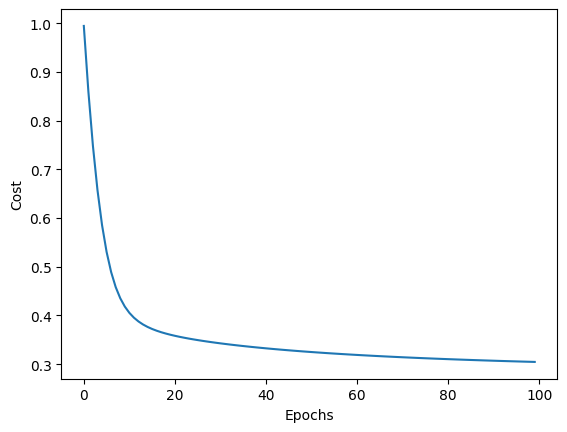

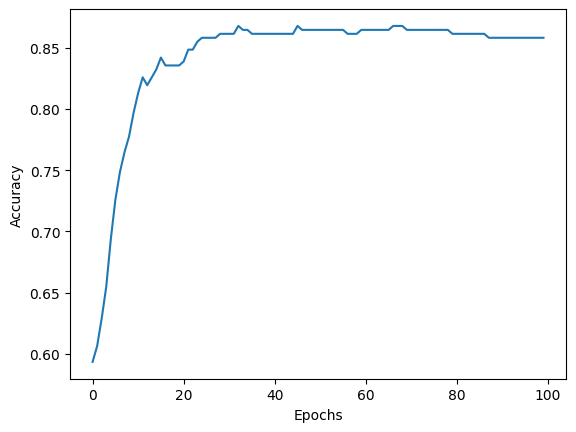

In [8]:
# adjust if needed
n_epochs = 100
learning_rate = 1.0

## initial parameter
W = torch.randn(13,1, dtype=torch.double)

# track the costs
costs = []
accuracies = []
# costs = [cost(X,Y,W)]
# accuracies = [accuracy(Y,predict(X,W))]

for epoch in range(n_epochs):
    W = W - learning_rate * gradient_cost(X,Y,W)
    costs.append(binary_cross_entropy_loss(X,Y,W))
    acc = accuracy(Y,predict(X,W))
    accuracies.append(acc)


# some output
print("Training Accuracy (max,end): %f, %f"%(np.max(accuracies), accuracies[len(accuracies)-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(n_epochs),costs)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.figure(2)
plt.plot(range(n_epochs),accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### 4. Implement Full Batch Gradient Descent with PyTorch's autograd

Epoch: 0: has loss on test set: 0.690943
Epoch: 1: has loss on test set: 0.624504
Epoch: 2: has loss on test set: 0.582121
Epoch: 3: has loss on test set: 0.552855
Epoch: 4: has loss on test set: 0.531434
Epoch: 5: has loss on test set: 0.515053
Epoch: 6: has loss on test set: 0.502085
Epoch: 7: has loss on test set: 0.491529
Epoch: 8: has loss on test set: 0.482733
Epoch: 9: has loss on test set: 0.475258
Epoch: 10: has loss on test set: 0.468801
Epoch: 11: has loss on test set: 0.463142
Epoch: 12: has loss on test set: 0.458124
Epoch: 13: has loss on test set: 0.453626
Epoch: 14: has loss on test set: 0.449558
Epoch: 15: has loss on test set: 0.445852
Epoch: 16: has loss on test set: 0.442450
Epoch: 17: has loss on test set: 0.439309
Epoch: 18: has loss on test set: 0.436395
Epoch: 19: has loss on test set: 0.433678
Epoch: 20: has loss on test set: 0.431133
Epoch: 21: has loss on test set: 0.428742
Epoch: 22: has loss on test set: 0.426487
Epoch: 23: has loss on test set: 0.424354
Ep

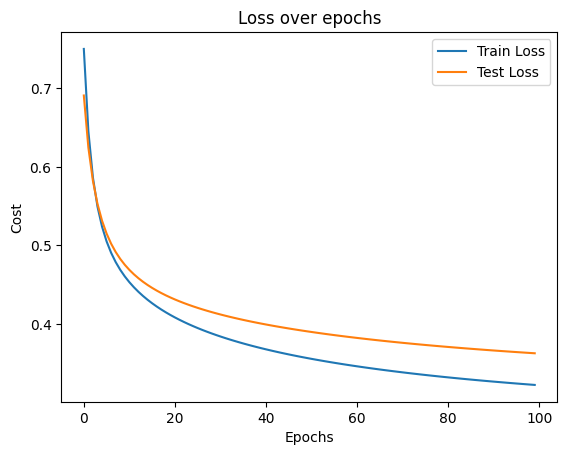

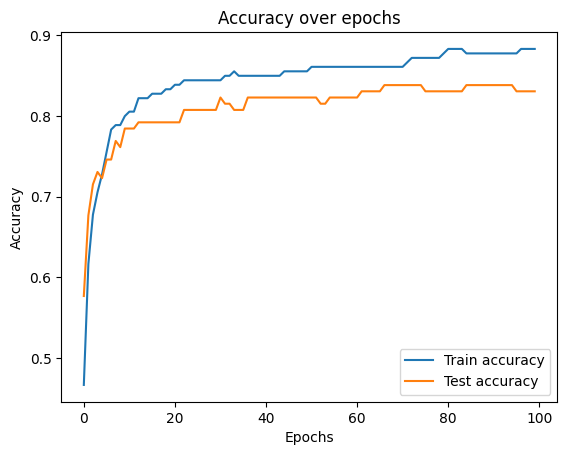

In [9]:
from torch import nn

linear = torch.nn.Linear(2, 1)

class BinaryLogistRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(BinaryLogistRegressionModel, self).__init__()
        self.flatten = nn.Sigmoid()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
       return  self.flatten(self.linear(x))


model = BinaryLogistRegressionModel(13, 1)

epochs = 100
learning_rate=0.5
cost = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


X_train = X[:180,:].float()
Y_train = Y[:180,:].float()

X_test = X[180:,:].float()
Y_test = Y[180:,:].float()

loss_list_on_train = []
loss_list_on_test = []
accuracy_list_test = []
accuracy_list_train = []

for epoch in range(epochs):
    pred = model(X_train)
    loss = cost(pred, Y_train)
    predicted_labels = (pred > 0.5).float()
    accuracy = (predicted_labels == Y_train.float()).float().mean().item()
    accuracy_list_train.append(accuracy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ce_loss = loss.squeeze().item()
    loss_list_on_train.append(ce_loss)
    
    # print("Epoch: %i: has loss on train set: %f" %(epoch, ce_loss))
    with torch.no_grad():
        pred = model(X_test)
        ce_loss_on_test = cost(pred, Y_test).squeeze().item()
        loss_list_on_test.append(ce_loss_on_test)
        predicted_labels = (pred > 0.5).float()
        accuracy = (predicted_labels == Y_test.float()).float().mean().item()
        accuracy_list_test.append(accuracy)
    print("Epoch: %i: has loss on test set: %f" %(epoch, ce_loss_on_test))
    
    
plt.plot(range(epochs), loss_list_on_train, label="Train Loss")
plt.plot(range(epochs), loss_list_on_test, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss over epochs")
plt.legend()

plt.figure(2)
plt.plot(range(epochs), accuracy_list_train, label="Train accuracy")
plt.plot(range(epochs), accuracy_list_test, label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

print("Final cost: ", ce_loss)

### 5. Tune Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.